In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
%matplotlib inline

In [2]:
od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_orig.csv')
od_matrix = od_matrix[~od_matrix.Destination.str.startswith('POE_')] ## Dropping points of entry

pop2018 = pd.read_csv('../data/pop_travel/DRC_Pop2018.csv')
pop2018['ADM2_caps'] = pop2018.ADM2_NAME.str.upper()

## Matching names from shape file or OD_matrix
match_dict = {'BAMBU':'BAMBU-MINES',
             'MONGBALU':'MONGBWALU',
             'NYAKUNDE':'NYANKUNDE',
             'KATOYI':'KITOYI'}
pop2018['ADM2_caps'] = pop2018.ADM2_caps.apply(lambda x: match_dict[x] if x in match_dict.keys() else x)

## Restricting analyses to Nord-Kivu and Ituri province health zones
pop2018 = pop2018[(pop2018.ADM1_NAME.isin(['Nord-Kivu','Ituri']))]
pop2018 = pop2018[['ADM2_caps','Pop2018']]

hzs = pop2018.ADM2_caps.values
od_matrix = od_matrix[(od_matrix.Origin.isin(hzs))&(od_matrix.Destination.isin(hzs))]

In [13]:
inter_hzs = {}
for h1 in hzs:
    inter_hzs[h1] = {}
    for h2 in hzs:
        inter_hzs[h1][h2] = []
        if h2==h1:
            continue
        inter_hzs[h1][h2].extend(list(od_matrix[(od_matrix.Origin==h1)&(od_matrix.Destination!=h2)&(od_matrix.Travel_Time<=od_matrix[(od_matrix.Origin==h1)&(od_matrix.Destination==h2)].Travel_Time.values[0])].Destination.values))        

In [14]:
interpop = {}
for h1 in hzs:
    interpop[h1] = {}
    for h2 in hzs:
        interpop[h1][h2] = pop2018[pop2018.ADM2_caps.isin(inter_hzs[h1][h2])].Pop2018.values.sum()
interpop = pd.DataFrame(interpop)

In [66]:
commute_frac = 0.15
temp = pop2018.copy(deep=True)
temp.Pop2018 = temp.Pop2018*commute_frac
tot = temp.set_index('ADM2_caps').to_dict()['Pop2018']

In [67]:
pop_dict = pop2018.set_index('ADM2_caps').to_dict()['Pop2018']

In [141]:
rad_flow = {}
for h1 in hzs:
    rad_flow[h1] = {}
    for h2 in hzs:
        if h1==h2:
            rad_flow[h1][h2] = (pop_dict[h1]-tot[h1])
        else:
            rad_flow[h1][h2] = tot[h1] * (pop_dict[h1] * pop_dict[h2])/ ((pop_dict[h1]+interpop[h1][h2]) * (pop_dict[h1]+pop_dict[h2]+interpop[h1][h2])) 
rad_df = pd.DataFrame(rad_flow)
for h in hzs:
    rad_flow[h][h] += (pop_dict[h] - rad_df[h].sum())
rad_df = pd.DataFrame(rad_flow)
rad_df = rad_df[sorted(rad_norm.columns)]
rad_norm = rad_df.transform(lambda x: x/x.sum(),axis=1)

### Comparison with gravity normalized flows

In [142]:
gt_df = pd.read_csv('../data/patchsim/calib_cps/grav_drc_v3.csv',delim_whitespace=True,usecols=[0,1,3],names=['src','dest','prob']).pivot(index='src',columns='dest',values='prob')

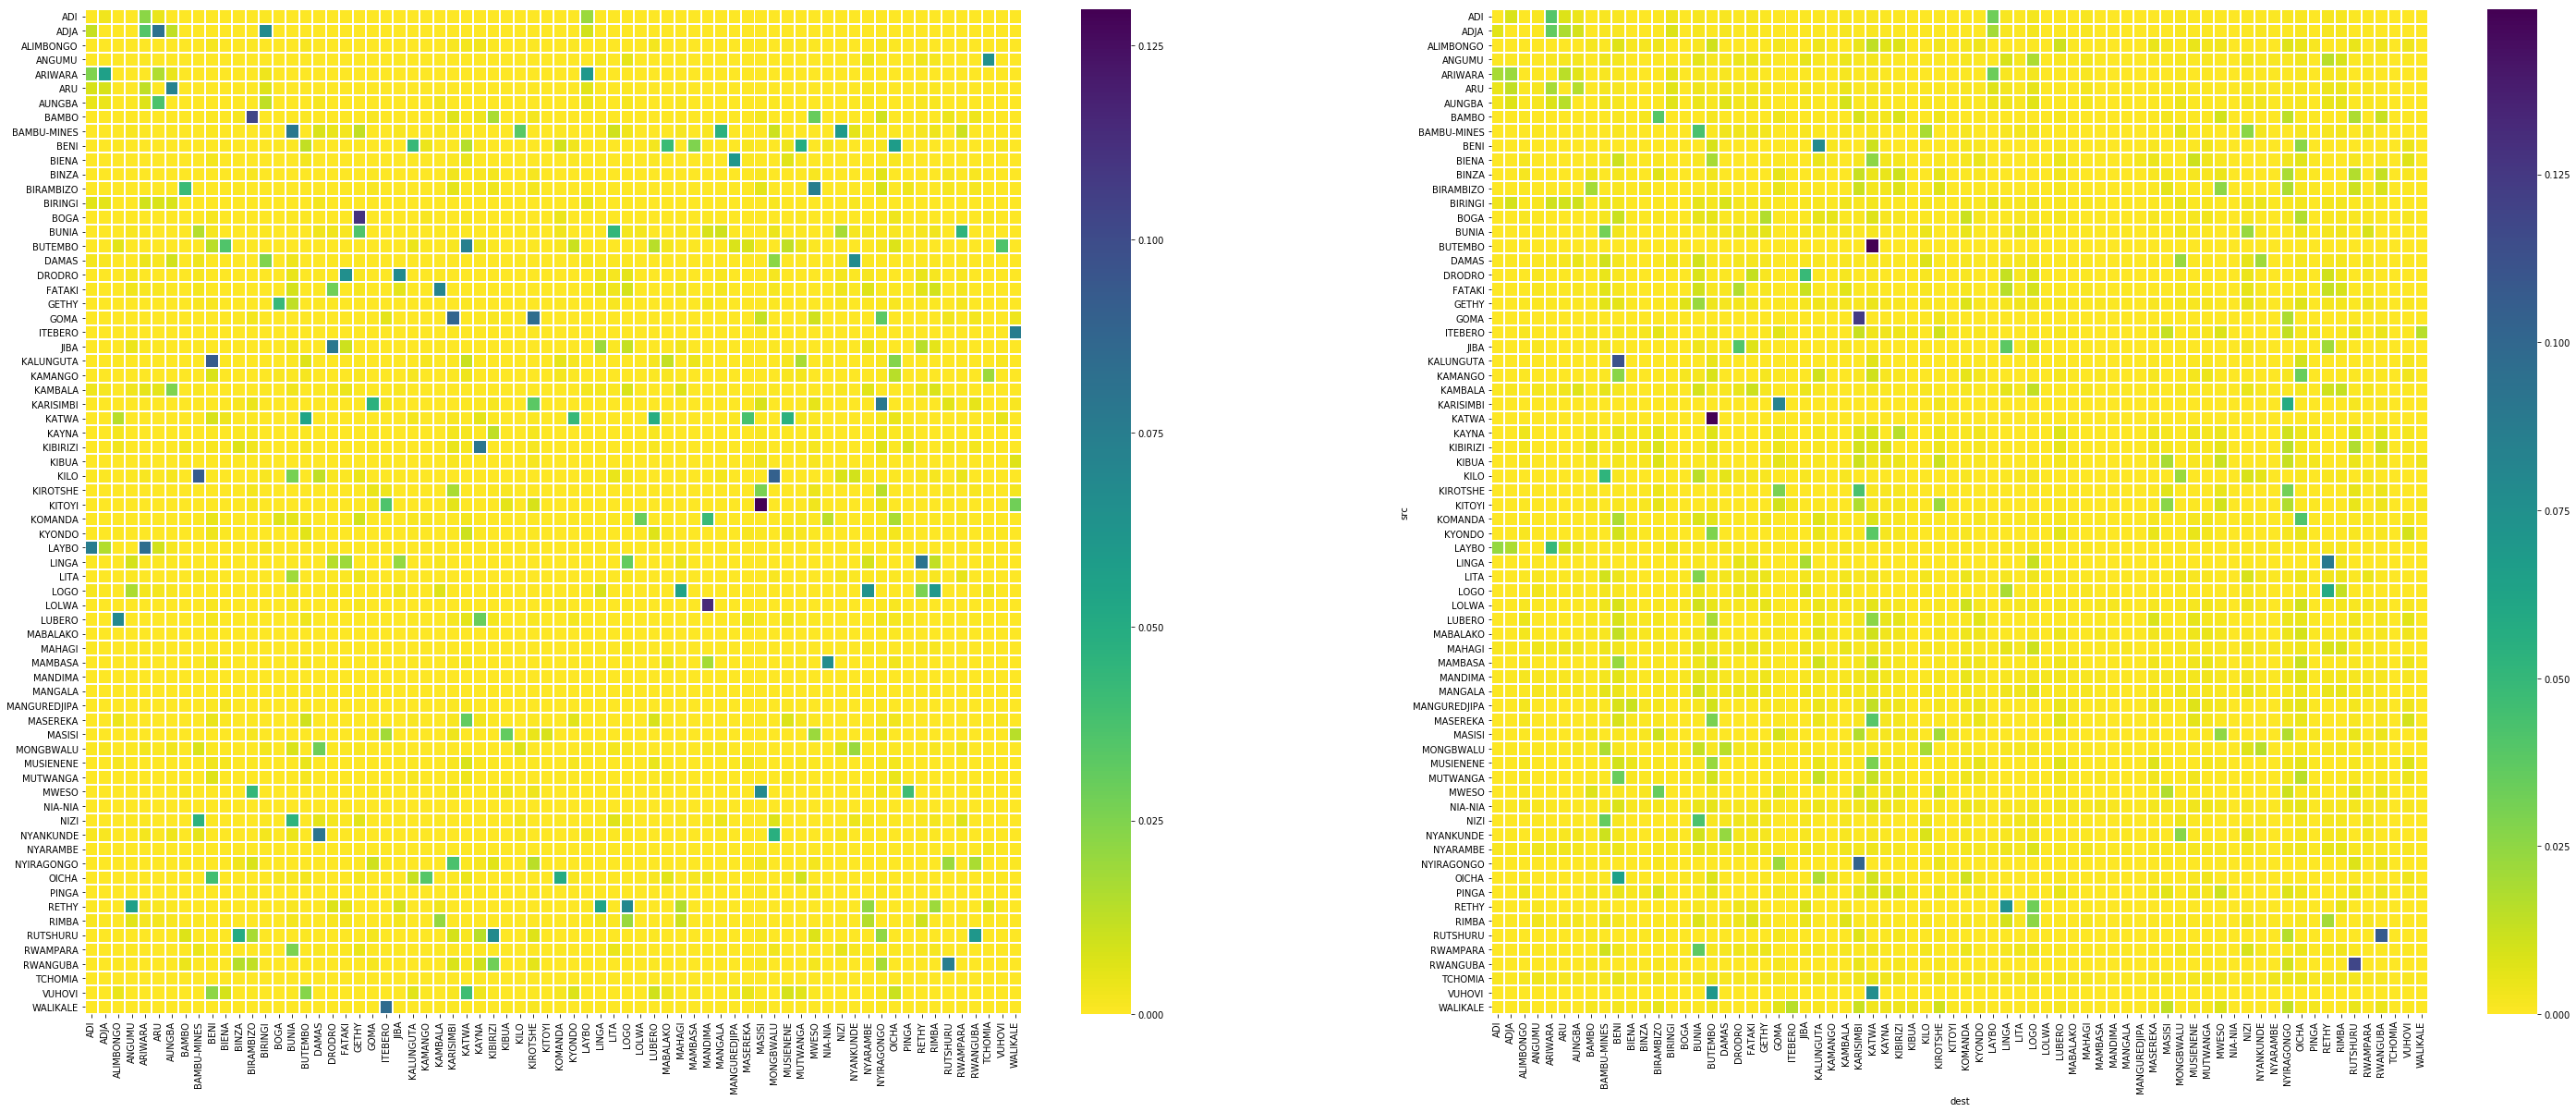

In [144]:
m1 = rad_norm.copy(deep=True)
m2 = gt_df.copy(deep=True)

np.fill_diagonal(m1.values, 0)
np.fill_diagonal(m2.values,0)

f,axarr = plt.subplots(1,2,figsize=(50,20))
sns.heatmap(m1, cmap=cm.viridis_r,ax=axarr[0],lw=1)
sns.heatmap(m2, cmap=cm.viridis_r,ax=axarr[1],lw=1)